In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import transforms as T

import os
cwd=os.getcwd()
os.chdir(cwd[:len('StableRemaster')+cwd.find('StableRemaster')])

from tqdm import tqdm

In [2]:
from src import *

In [3]:
DATA_PATH = './data/02_scenes/'

In [4]:
def display_masked_image(im, mask):
    new_im = cv2.bitwise_and(im , im , mask = mask)
    plt.imshow(new_im)

def stitch_images(image1, image2, mask1, mask2, scale=1):
    # Detect features and keypoints using SIFT
    sift = cv2.SIFT_create()
    #display_masked_image(image1,mask1)
    keypoints1, descriptors1 = sift.detectAndCompute(image1, mask1)
    keypoints2, descriptors2 = sift.detectAndCompute(image2, mask2)

    # Match the features using FLANN-based matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    # Filter good matches using the ratio test
    good_matches = []
    for pair in matches:
        if len(pair) == 2:
            m, n = pair
            if m.distance < 0.5 * n.distance:
                good_matches.append(m)

    if len(good_matches) < 10:  # Minimum number of matches required for homography
        print("Not enough good matches found to stitch the images.")
        return image1, mask1, image1

    # Extract the matched points
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Compute the homography using RANSAC
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 8.0)

    # Warp image2 using the computed homography
    h, w = image1.shape[:2]
    warped_image2 = cv2.warpPerspective(image2, H, (w, h))
    warped_mask = cv2.warpPerspective(mask2,H, (w,h))

    stitched_mask = np.any([mask1,warped_mask],axis=0).astype('uint8')
    
    masked_im1 = cv2.bitwise_and(image1 , image1 , mask = mask1).astype('uint8')
    masked_im2 = cv2.bitwise_and(warped_image2 , warped_image2 , mask = warped_mask).astype('uint8')
    
    warped_mask = warped_mask/scale
    masked_im2 = masked_im2/scale
    
    mask_count = np.sum([mask1,warped_mask],axis=0)
    mask_count[np.where(mask_count==0)]=1
    im_sum = np.sum([masked_im1,masked_im2],axis=0)
    
    averaged_image = (im_sum/np.expand_dims(mask_count, axis=-1)).astype('uint8')
    
    return averaged_image, stitched_mask


def stitch_multiple(images, masks):
    if len(images) < 2:
        raise ValueError("At least two images are required for stitching.")

    stitched_image = images[0]
    stitched_mask = masks[0]
    
    for i in tqdm(range(1, len(images))):
        stitched_image, stitched_mask = stitch_images(stitched_image, images[i], stitched_mask, masks[i],scale=i)
    return stitched_image,stitched_mask

In [5]:
cap_path = f'{DATA_PATH}atla_s1e1-Scene-151.mp4'
frames = split_video(cap_path)

In [6]:
segmenter = background_segmentation_loader()

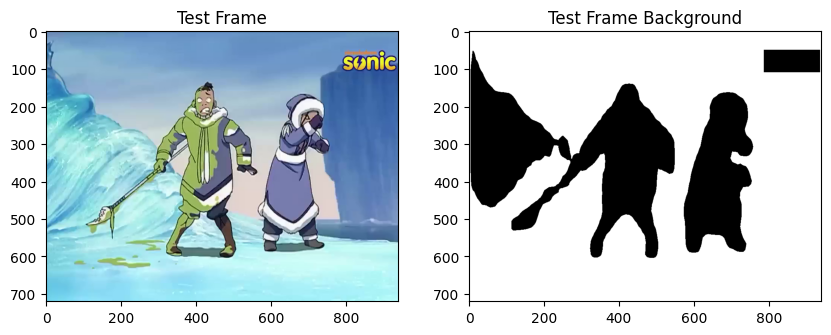

In [7]:
test_frame1 = frames[0]

bg1,bg_mask1 = segmenter(test_frame1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(test_frame1, cmap='gray')
ax1.set_title('Test Frame')

ax2.imshow(bg_mask1, cmap='gray')
ax2.set_title('Test Frame Background')

# show the figure
plt.show()

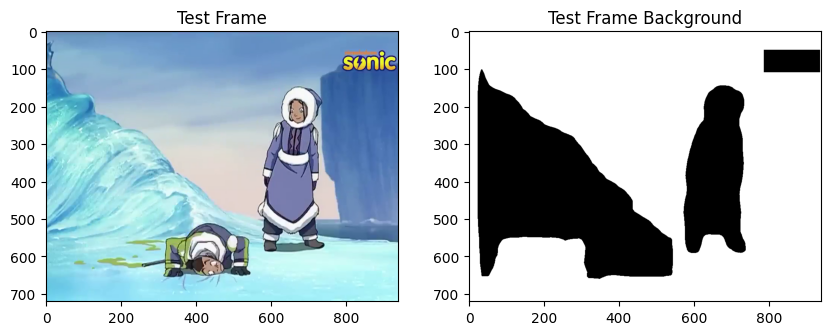

In [8]:
test_frame2 = frames[100]

bg2, bg_mask2 = segmenter(test_frame2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(test_frame2, cmap='gray')
ax1.set_title('Test Frame')

ax2.imshow(bg_mask2, cmap='gray')
ax2.set_title('Test Frame Background')

# show the figure
plt.show()

In [18]:
masks = []
bgs = []
for frame in tqdm(frames):
    bg, bg_mask = segmenter(frame,mask_conf=0.2,cat_conf=0.4)
    masks.append(bg_mask)
    bgs.append(bg)

100%|█████████████████████████████████████████| 132/132 [06:01<00:00,  2.74s/it]


In [19]:
total_bg, total_mask = stitch_multiple(frames, masks)

100%|█████████████████████████████████████████| 131/131 [00:38<00:00,  3.43it/s]


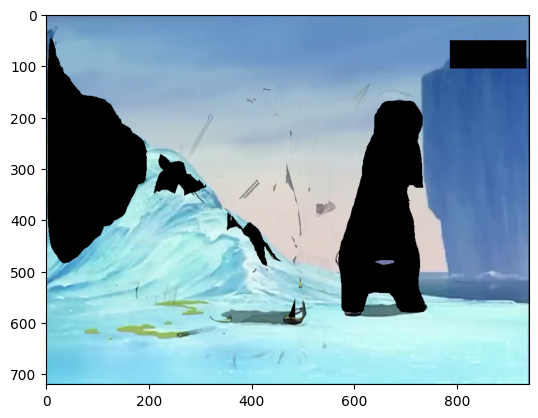

In [20]:
plt.imshow(total_bg,'gray')